# Assignment 3
In Assignment 3, we consider a random coefficient model **without the unobserved fixed effects.** 
- Description of Assignment 3: [link](https://kohei-kawaguchi.github.io/EmpiricalIO/assignment3.html)

In [1]:
# import packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
from numba import jit, njit, prange
import matplotlib.pyplot as plt

# 1 Simulate data

## 1.1 Set the seed, constants, and parameters of interest.

In [194]:
# set the seed
np.random.seed(310)
# number of products
J = 10
# dimension of product characteristics including the intercept (=1)
K = 3
# number of markets
T = 100
# number of consumers per market
N = 500
# number of Monte Carlo
L = 1000

- $[\beta_{01}, \cdots, \beta_{0K}]$ is referred to as beta.
- $[\sigma_{1}, \cdots, \sigma_{K}]$ is referred to as sigma.

In [89]:
# set parameters of interest
beta = np.random.standard_normal(size = (K,1))
beta[0] = 4

print('beta: ', beta)

sigma = abs(np.random.standard_normal(size = (K,1))) 
print('sigma: ', sigma)

mu = 0.5
omega = 1

beta:  [[ 4.        ]
 [-0.46637271]
 [-0.74021613]]
sigma:  [[1.7571458 ]
 [0.1486    ]
 [0.11806668]]


In [7]:
# set auxiliary parameters
price_xi = 1
prop_jt = 0.6
sd_x = 0.5
sd_c = 0.05
sd_p = 0.05

## 1.2 X
X is the data frame such that a row contains the characteristics vector $x_j$ of a product and columns are product index and observed product characteristics. The dimension of the characteristics $K$ is specified above. Add the row of the outside option whose index is 0 and all the characteristics are zero.

- The product-market characteristics: $$x_{j1}=1, x_{jk}\sim N(0, \sigma_x), k=2,\cdots,K,$$ where $\sigma_x$ is referred to as sd_x in the code.

In [100]:
X = np.random.normal(scale = sd_x, size = (J,K-1))
X = pd.DataFrame(X, columns = ['x_2', 'x_3'])
X['x_1'] = 1

X

,x_2,x_3,x_1
0,0.440811,-0.160323,1
1,-0.747617,0.227789,1
2,1.115339,0.328095,1
3,-0.398086,0.621501,1
4,-0.092434,-0.139086,1
5,-0.343645,-0.423325,1
6,0.258434,-1.030174,1
7,-0.077813,-0.825724,1
8,0.302078,0.184634,1
9,0.751401,0.281817,1


In [107]:
# X product-market characteristics
X = np.random.normal(scale = sd_x, size = (J+1,K-1))
X = pd.DataFrame(X, columns = ['x_2', 'x_3'])
X['x_1'] = 1
X['j'] = X.index
X.loc[X['j'] == 0, ['x_1', 'x_2', 'x_3']] = 0

print('shape of X: ', X.shape)
X.head()

shape of X:  (11, 4)


,x_2,x_3,x_1,j
0,0.000000,0.000000,0,0
1,0.422176,-0.291138,1,1
2,0.035364,0.280590,1,2
3,0.595675,-0.218182,1,3
4,0.548943,0.236448,1,4


## 1.3 M
M is the data frame such that a row contains the product-market specific fixed effect $\xi_{jt}$, marginal cost $c_{jt}$, and price $p_{jt}$. After generating the variables, drop 1 - prop_jt products from each market. The variation in the available products is important for the identification of the distribution of consumer-level unobserved heterogeneity. Add the row of the outside option to each market whose index is 0 and all the variables take value zero.
- The product-market-specific unobserved fixed effect: $$\xi_{jt}=0.$$

- The marginal cost of product $j$ in market $t$: $$c_{jt}\sim logNormal(0, \sigma_c),$$ where $\sigma_c$ is referred to as sd_c in the code.
- The retail price: $$p_{jt}-c_{jt} \sim logNormal(\gamma \xi_{jt}, \sigma_p),$$ where $\gamma$ is referred to as price_xi, and $\sigma_p$ as sd_p in the code. This price is not the equilibrium price.

In [179]:
# j = 1, 2, ..., J; t = 1, 2, ..., T
M = pd.DataFrame([(j+1,1) for j in range(J)], columns = ['j', 'temp'])\
.merge(pd.DataFrame([(t+1,1) for t in range(T)], columns = ['t', 'temp']), how = 'outer')
M.drop(columns = 'temp', inplace =True)

M['xi'] = 0
M['c'] = np.random.lognormal(sigma = sd_c, size = (len(M),1))
M['p'] = M.apply(lambda x: np.random.lognormal(mean = price_xi * x.xi, sigma = sd_p), axis = 1)
M['p'] = M['p'] + M['c']

M.sort_values(by = ['t', 'j'], inplace = True)

# drop 1 - prop_jt products from each market
M = M.groupby("t").sample(frac = prop_jt, random_state = 230)

# add the row of the outside option to each market whose index is 0 and all the variables take value zero.
# M.loc[M.j == 0, ['xi','c', 'p']] = 0
temp1 = M[['t']].drop_duplicates()
for col in ['j', 'xi', 'c', 'p']:
    temp1[col] = np.zeros(shape = (len(temp1), 1))

M = pd.concat([M, temp1])
print('shape of M: ', M.shape)
M.head()

shape of M:  (700, 5)


,j,t,xi,c,p
500,6.0,1,0.0,1.103263,2.054850
400,5.0,1,0.0,1.087104,2.117463
700,8.0,1,0.0,1.024814,2.022961
600,7.0,1,0.0,0.945428,1.945832
100,2.0,1,0.0,0.955670,1.982614


## 1.4 V
Generate the consumer-level heterogeneity. V is the data frame such that a row contains the vector of shocks to consumer-level heterogeneity, $(v_i', v_i)$ . They are all i.i.d. standard normal random variables.

- $\beta_{itk} = \beta_{0k} + \sigma_k v_{itk},$ where $v_{itk}$ for $k=1,2,\cdots, K$ are i.i.d. standard normal random variables.
  
- $\alpha_{it} = -exp(\mu + \omega v_{it}) = -exp(\mu + \omega^2/2) + [-exp(\mu + \omega v_{it}) + exp(\mu + \omega^2/2)] = \alpha_0 + \tilde{\alpha}_{it},$ where $v_{it}$ are i.i.d. standard normal random variables.

In [180]:
V = pd.DataFrame([(i+1,1) for i in range(N)], columns = ['i', 'temp'])\
.merge(pd.DataFrame([(t+1,1) for t in range(T)], columns = ['t', 'temp']), how = 'outer')
V.drop(columns = 'temp', inplace =True)
for col in ['v_x_1', 'v_x_2', 'v_x_3', 'v_p']:
    V[col] = np.random.normal(size = (N*T, 1))

print('shape of V: ', V.shape)
V.head()

shape of V:  (50000, 6)


,i,t,v_x_1,v_x_2,v_x_3,v_p
0,1,1,-0.086080,-0.151661,0.489842,0.723222
1,1,2,0.515722,-1.088453,-0.118181,1.225763
2,1,3,-0.603289,0.589829,-0.932829,-0.775375
3,1,4,-1.219546,-0.543320,0.947544,0.567564
4,1,5,-0.593763,-1.160911,-1.571937,-0.310318


## 1.5 df
Join $X$, $M$, $V$ and name it df. df is the data frame such that a row contains variables for a consumer about a product that is available in a market.

In [222]:
df = X.merge(M, how = 'left')
df = df.merge(V, how = 'left')
df.sort_values(by = ['t', 'i', 'j'], inplace =True)

print('shape of df: ', df.shape)
df.head()

shape of df:  (350000, 13)


,x_2,x_3,x_1,j,t,xi,c,p,i,v_x_1,v_x_2,v_x_3,v_p
0,0.000000,0.000000,0,0,1,0.0,0.000000,0.000000,1,-0.08608,-0.151661,0.489842,0.723222
81000,0.035364,0.280590,1,2,1,0.0,0.955670,1.982614,1,-0.08608,-0.151661,0.489842,0.723222
112000,0.595675,-0.218182,1,3,1,0.0,1.004835,1.995777,1,-0.08608,-0.151661,0.489842,0.723222
177500,-0.378450,-0.138894,1,5,1,0.0,1.087104,2.117463,1,-0.08608,-0.151661,0.489842,0.723222
208000,-0.746755,0.066893,1,6,1,0.0,1.103263,2.054850,1,-0.08608,-0.151661,0.489842,0.723222


## 1.6 e
Draw a vector of preference shocks e whose length is the same as the number of rows of df.

In [182]:
e = np.random.gumbel(size = (len(df), 1))

print('shape of e: ', e.shape)

e

shape of e:  (350000, 1)


array([[-0.71178267],
       [ 1.77719766],
       [ 2.02218055],
       ...,
       [ 2.50853542],
       [ 2.28801195],
       [ 3.49553729]])

## 1.7 compute indirect utility (df, beta, sigma, mu, omega)
Write a function compute_indirect_utility(df, beta, sigma, mu, omega) that returns a vector whose element is the mean indirect utility of a product for a consumer in a market. The output should have the same length with e.

The indirect utility of consumer $i$ in market $t$ for product $j$ is: $$u_{itj}=\beta_{it}'x_j + \alpha_{it}p_{jt} +\xi_{jt} + \epsilon_{ijt}$$

$\beta_{it}$ and $\alpha_{it}$ are different across consumers, and they are distributed as:
- $\beta_{itk} = \beta_{0k} + \sigma_k v_{itk},$ where $v_{itk}$ for $k=1,2,\cdots, K$ are i.i.d. standard normal random variables.
  
- $\alpha_{it} = -exp(\mu + \omega v_{it}) = -exp(\mu + \omega^2/2) + [-exp(\mu + \omega v_{it}) + exp(\mu + \omega^2/2)] = \alpha_0 + \tilde{\alpha}_{it},$ where $v_{it}$ are i.i.d. standard normal random variables.
  - $[\beta_{01}, \cdots, \beta_{0K}]$ is referred to as beta.
  - $[\sigma_{1}, \cdots, \sigma_{K}]$ is referred to as sigma.

In [120]:
# compute indirect utility (df, beta, sigma, mu, omega)
def compute_indirect_utility(df, beta, sigma, mu, omega):
    u = (beta[0]+sigma[0]*df.v_x_1)*df.x_1 + (beta[1]+sigma[1]*df.v_x_2)*df.x_2 + (beta[2]+sigma[2]*df.v_x_3)*df.x_3 + \
    np.exp(mu + omega*df.v_p)*df.p + \
    df.xi
    return u

In [121]:
u = compute_indirect_utility(df, beta, sigma, mu, omega)

print('shape of u: ', u.shape)

u

shape of u:  (350000,)


35500     5.694845
67000     5.351453
130500    5.231400
163000    6.032167
195000    5.935393
            ...   
130499    7.211355
194999    7.773737
256999    7.336684
284499    7.827426
349999    7.004199
Length: 350000, dtype: float64

## 1.8 compute_choice(df, e, beta, sigma, mu, omega)
Write a function compute_choice(df, e, beta, sigma, mu, omega). Call compute_indirect_utility to obtain the vector of mean indirect utilities u, next compute the choice vector q based on the vector of mean indirect utilities and e, and finally return the data frame to which u and q are added as columns.

Given a choice set in the market,$J_{t}\cup \{0\}$, a consumer chooses the alternative that maximizes her utility:
$$q_{ijt}=1\{u_{ijt} = \underset{k\in J_{t}\cup \{0\}}{max} u_{ikt}\}.$$

- The choice probability of product $j$ for consumer $i$ in market $t$ is:
$\sigma_{jt}(p_t, x_t, \xi_t)=\mathbb{P}\{u_{ijt} = \underset{k\in J_{t}\cup \{0\}}{max} u_{ikt}\}$

In [183]:
def compute_choice(df, e, beta, sigma, mu, omega):
    df['u'] = compute_indirect_utility(df, beta, sigma, mu, omega)
    df['e'] = e
    df['u_plus_e'] = df['u'] + df['e']
    temp = df.groupby(['i', 't']).agg({'u_plus_e':'max'}).reset_index()
    temp.columns = ['i', 't', 'max_u_plus_e']
    df = df.merge(temp, how = 'left')
    df['q'] = (df['u_plus_e'] == df['max_u_plus_e']).astype('int')
    df.drop(columns = ['u_plus_e', 'e', 'max_u_plus_e'], inplace = True)
    return df

In [184]:
df = compute_choice(df, e, beta, sigma, mu, omega)

print('shape of df: ', df.shape)
df.describe()

shape of df:  (350000, 15)


,x_2,x_3,x_1,j,t,xi,c,p,i,v_x_1,v_x_2,v_x_3,v_p,u,q
count,350000.000000,350000.000000,350000.000000,350000.000000,350000.000000,350000.0,350000.000000,350000.000000,350000.000000,350000.000000,350000.000000,350000.000000,350000.000000,350000.000000,350000.000000
mean,-0.002871,0.088543,0.857143,4.578571,50.500000,0.0,0.860168,1.716846,250.500000,0.007630,-0.000486,0.004958,0.002752,8.065193,0.142857
std,0.399159,0.313574,0.349928,3.233463,28.866111,0.0,0.354315,0.703978,144.337485,1.001887,1.000476,0.996175,0.999915,7.693710,0.349928
min,-0.746755,-0.291138,0.000000,0.000000,1.000000,0.0,0.000000,0.000000,1.000000,-4.176301,-3.912019,-4.209944,-4.097605,-2.412469,0.000000
25%,-0.378450,-0.211996,1.000000,2.000000,25.750000,0.0,0.944178,1.918152,125.750000,-0.670229,-0.670948,-0.662437,-0.668071,4.284932,0.000000
50%,0.000000,0.066893,1.000000,4.000000,50.500000,0.0,0.990393,1.985272,250.500000,0.013758,0.000120,0.006999,-0.000006,6.895875,0.000000
75%,0.422176,0.242568,1.000000,7.000000,75.250000,0.0,1.031363,2.043085,375.250000,0.681411,0.675261,0.680358,0.677225,10.081387,0.000000
max,0.595675,0.908770,1.000000,10.000000,100.000000,0.0,1.215445,2.228248,500.000000,4.281156,3.809946,3.902888,4.375160,280.205530,1.000000


## 1.9 compute_share(df, e, beta, sigma, mu, omega)
Write a function compute_share(df, e, beta, sigma, mu, omega). First call compute_choice to obtain a data frame with u and q, second compute the share of each product at each market s and the log difference in the share from the outside option, $ln(s_{jt}/s_{0t})$, denoted by y, and finally return the data frame that is summarized at the product-market level, dropped consumer-level variables, and added s and y.

The share: $$s_{jt}=\frac{1}{N}\sum_{i=1}^N q_{ijt}$$

In [231]:
def compute_share(df, e, beta, sigma, mu, omega):
    df = compute_choice(df, e, beta, sigma, mu, omega)
    df['e'] = e
    temp1 = df.groupby(['j', 't', 'x_2', 'x_3', 'x_1', 'xi', 'c', 'p']).agg({'q': 'mean'}).reset_index()
    temp1.columns = ['j', 't', 'x_2', 'x_3', 'x_1', 'xi', 'c', 'p', 's']

    temp2 = temp1.loc[temp1.j == 0, ['t','s']]
    temp2.columns = ['t', 's_0']
    temp3 = temp2[temp2['s_0'] <= 0][['t']]
    temp3 = temp3.merge(df[df.j == 0], how = 'left')
    temp3 = temp3.groupby(['t']).agg({'e': 'mean'}).reset_index()
    temp3['ln_s_0'] = -temp3['e']
    temp3['s_0'] = np.exp(temp3['ln_s_0'])
    temp2 = temp2[temp2['s_0'] > 0]
    temp2['ln_s_0'] = np.log(temp2['s_0'])
    temp2 = pd.concat([temp2[['t', 's_0', 'ln_s_0']], temp3[['t', 's_0', 'ln_s_0']]])
    
    temp1 = temp1.merge(temp2, how = 'left')
    temp1['s'] = temp1.apply(lambda x: x.s_0 if (x.j == 0 and x.s <= 0) else x.s, axis = 1)
    temp1['y'] = np.log(temp1['s']) - temp1['ln_s_0']
    temp1.loc[temp1.j == 0, 'y'] = 0
    return temp1[['j', 't', 'x_2', 'x_3', 'x_1', 'xi', 'c', 'p', 's', 'y']]

In [232]:
df = compute_share(df, e, beta, sigma, mu, omega)

print('shape of df: ', df.shape)
df.head()

shape of df:  (700, 10)


,j,t,x_2,x_3,x_1,xi,c,p,s,y
0,0,1,0.0,0.0,0,0.0,0.0,0.0,0.004000,0.0
1,0,2,0.0,0.0,0,0.0,0.0,0.0,0.002000,0.0
2,0,3,0.0,0.0,0,0.0,0.0,0.0,0.002000,0.0
3,0,4,0.0,0.0,0,0.0,0.0,0.0,0.553628,0.0
4,0,5,0.0,0.0,0,0.0,0.0,0.0,0.004000,0.0


# 2  Estimate the parameters

## 2.1 Assume there is no consumer-level heterogeneity
The probability that consumer $i$ will choose product $j$ 
$$p_{ijt}(v_i)=\frac{exp(\delta_{jt}+v_{ijt})}{1+\sum_{k=1}^J exp(\delta_{kt}+v_{ikt})}.$$

The market shares is, e.g., 
      $$s_{jt}=\frac{exp(\beta'x_{jt} + \alpha p_{jt} +\xi_{jt})}{1+\sum_{k=1}^J exp(\beta'x_k + \alpha p_{kt} +\xi_{kt})}$$ since there is no consumer-level heterogeneity

Transform the above expression.
- $log(s_{jt})=(\beta'x_{jt} + \alpha p_{jt} +\xi_{jt}) - log(1+\sum_{k=1}^J exp(\beta'x_{kt} + \alpha p_{kt} +\xi_{kt}))$
- $log(s_{jt})=(\beta'x_{jt} + \alpha p_{jt} +\xi_{jt}) + e_t$ where $e_t = - log(1+\sum_{k=1}^J exp(\beta'x_{kt} + \alpha p_{kt} +\xi_{kt}))$

If we normalize the utility of the outside good to zero, this implies that: 
- $s_{0t}=\frac{exp(0)}{1+\sum_{k=1}^J exp(\beta'x_k + \alpha p_{kt} +\xi_{kt})} = \frac{1}{exp(-e_t)},$
- $\Longrightarrow log(s_{0t}) = 0 - e_t$


Estimate the parameters assuming there is no consumer-level heterogeneity, i.e., by assuming:
$$ln(\frac{s_{jt}}{s_{0t}}) = \beta' x_{jt} + \alpha p_{jt}$$

In [338]:
df = X.merge(M, how = 'left')
df = df.merge(V, how = 'left')

df_share = compute_choice(df, e, beta, sigma, mu, omega)
df_share = compute_share(df_share, e, beta, sigma, mu, omega)

In [339]:
ols_res = sm.OLS.from_formula('y ~ -1 + x_1 + x_2 + x_3 + p', data = df_share).fit()
print(ols_res.summary2(float_format="%.6f"))

                        Results: Ordinary least squares
Model:                  OLS              Adj. R-squared (uncentered): 0.338    
Dependent Variable:     y                AIC:                         3257.3087
Date:                   2021-08-27 18:10 BIC:                         3275.5130
No. Observations:       700              Log-Likelihood:              -1624.7  
Df Model:               4                F-statistic:                 90.44    
Df Residuals:           696              Prob (F-statistic):          6.64e-62 
R-squared (uncentered): 0.342            Scale:                       6.1088   
------------------------------------------------------------------------------------
             Coef.       Std.Err.         t         P>|t|        [0.025       0.975]
------------------------------------------------------------------------------------
x_1         -4.1785        2.8514      -1.4654      0.1433      -9.7768       1.4198
x_2         -0.3657        0.2526      -1.44

## 2.2

In [340]:
# The number of simulations is L

V_mcmc = pd.DataFrame([(i+1,1) for i in range(L)], columns = ['i', 'temp'])\
.merge(pd.DataFrame([(t+1,1) for t in range(T)], columns = ['t', 'temp']), how = 'outer')
V_mcmc.drop(columns = 'temp', inplace =True)
for col in ['v_x_1', 'v_x_2', 'v_x_3', 'v_p']:
    V_mcmc[col] = np.random.normal(size = (L*T, 1))

print('shape of V_mcmc: ', V_mcmc.shape)
V_mcmc.head()

shape of V_mcmc:  (100000, 6)


,i,t,v_x_1,v_x_2,v_x_3,v_p
0,1,1,-0.964850,2.106239,-1.324508,0.779572
1,1,2,-0.242827,0.998295,1.350968,1.747766
2,1,3,1.733645,-0.570624,0.824429,-0.493763
3,1,4,0.395297,-1.359708,0.652422,2.277985
4,1,5,0.930536,0.433377,-0.296047,0.442123


In [341]:
df_mcmc = X.merge(M, how = 'left')
df_mcmc = df_mcmc.merge(V_mcmc, how = 'left')

print('shape of df_mcmc: ', df_mcmc.shape)
df_mcmc.head()

shape of df_mcmc:  (700000, 13)


,x_2,x_3,x_1,j,t,xi,c,p,i,v_x_1,v_x_2,v_x_3,v_p
0,0.0,0.0,0,0,1,0.0,0.0,0.0,1,-0.964850,2.106239,-1.324508,0.779572
1,0.0,0.0,0,0,1,0.0,0.0,0.0,2,0.039252,-0.698739,-0.005503,-0.853507
2,0.0,0.0,0,0,1,0.0,0.0,0.0,3,0.618297,-1.136635,-1.655252,-0.391188
3,0.0,0.0,0,0,1,0.0,0.0,0.0,4,0.266054,-1.033895,-0.448791,1.519259
4,0.0,0.0,0,0,1,0.0,0.0,0.0,5,1.061019,0.492390,0.075651,0.714045


In [344]:
e_mcmc = np.random.gumbel(size = (len(df_mcmc), 1))

print('shape of e_mcmc: ', e_mcmc.shape)
e_mcmc

shape of e_mcmc:  (700000, 1)


array([[ 1.31752324],
       [-0.24136139],
       [-0.65230721],
       ...,
       [-0.27556836],
       [ 0.85195082],
       [-1.2651798 ]])

## 2.3

In [345]:
df_mcmc = compute_choice(df_mcmc, e_mcmc, beta, sigma, mu, omega)
df_share_mcmc = compute_share(df_mcmc, e_mcmc, beta, sigma, mu, omega)

print('shape of df_share_mcmc: ', df_share_mcmc.shape)
df_share_mcmc.head()

shape of df_share_mcmc:  (700, 10)


,j,t,x_2,x_3,x_1,xi,c,p,s,y
0,0,1,0.0,0.0,0,0.0,0.0,0.0,0.569749,0.0
1,0,2,0.0,0.0,0,0.0,0.0,0.0,0.593663,0.0
2,0,3,0.0,0.0,0,0.0,0.0,0.0,0.004000,0.0
3,0,4,0.0,0.0,0,0.0,0.0,0.0,0.003000,0.0
4,0,5,0.0,0.0,0,0.0,0.0,0.0,0.003000,0.0


## 2.4

In [346]:
# set parameters
theta = beta.flatten().tolist()

for item in sigma.flatten().tolist():
    theta.append(item)
    
theta.append(mu)
theta.append(omega)

In [380]:
theta

[4.0,
 -0.46637270638775613,
 -0.7402161317158423,
 1.7571458013055348,
 0.1485999998327376,
 0.11806668153127585,
 0.5,
 1]

## 2.5

Write a function NLLS_objective(theta, df_share, X, M, V_mcmc, e_mcmc) that first computes the simulated share and then compute the mean-squared error between the share data.

In [349]:
def NLLS_objective(theta, df_share, X, M, V_mcmc, e_mcmc):
    beta = theta[0:3]
    sigma = theta[3:6]
    mu = theta[6]
    omega = theta[7]
    
    df_mcmc = X.merge(M, how = 'left')
    df_mcmc = df_mcmc.merge(V_mcmc, how = 'left')
    
    df_mcmc = compute_choice(df_mcmc, e_mcmc, beta, sigma, mu, omega)
    df_share_mcmc = compute_share(df_mcmc, e_mcmc, beta, sigma, mu, omega)  
    
    return np.power((df_share['s'] - df_share_mcmc['s']), 2).mean()

In [350]:
NLLS_objective(theta, df_share, X, M, V_mcmc, e_mcmc)

0.019209796202789953

## 2.6

Draw a graph of the objective function that varies each parameter from 0.5, 0.6, ⋯, 1.5 of the true value. First try with the actual shocks V and e and then try with the Monte Carlo shocks V_mcmc and e_mcmc. You will some of the graph does not look good with the Monte Carlo shocks. It will cause the approximation error.

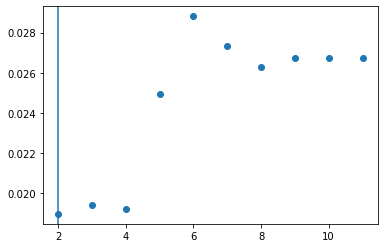

In [391]:
# The graphs with the Monte Carlo shocks:
output = []

for para in [i+2 for i in range(10)]:
    theta_try = theta.copy()
    theta_try[0] = para
    mse = NLLS_objective(theta_try, df_share, X, M, V_mcmc, e_mcmc)
    output.append([para, mse])

output = pd.DataFrame(output, columns =['beta_1', 'objective'])

plt.scatter(output['beta_1'], output['objective'])
plt.axvline(x = output.loc[output['objective'] == output['objective'].min(), 'beta_1'].values[0])
plt.show()

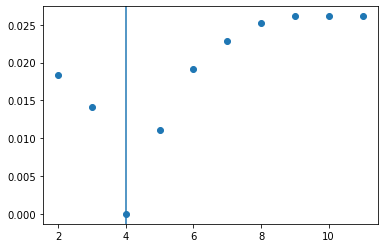

In [390]:
# The graphs with the true shocks:
output = []

for para in [i+2 for i in range(10)]:
    theta_try = theta.copy()
    theta_try[0] = para
    mse = NLLS_objective(theta_try, df_share, X, M, V, e)
    output.append([para, mse])

output = pd.DataFrame(output, columns =['beta_1', 'objective'])

plt.scatter(output['beta_1'], output['objective'])
plt.axvline(x = output.loc[output['objective'] == output['objective'].min(), 'beta_1'].values[0])
plt.show()